## Speech Emotion Recognition
### Mahua Dwivedi

### Importing Libraries and datasets

In [1]:
import numpy as np 
import pandas as pd
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print("done")

done


In [2]:
data=pd.read_csv(r'C:\mahua\Projects\INTERNSHIPS\CodeClause\Speech Emotion Recognition\features.csv')

In [3]:
x = data.iloc[: ,:-1].values
y = data['labels'].values

encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=24, shuffle=True)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((375, 20, 1), (375, 16), (125, 20, 1), (125, 16))

### Building LSTM

In [4]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 2048)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 2048)         8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 1024)          0         
 1D)                                                             
                                                        

In [5]:
K.set_value(model.optimizer.learning_rate, 0.01)

In [6]:
# Fitting RNN into training set
history = model.fit(x_train, y_train, batch_size=256, epochs=25)

Epoch 1/25
2/2 [==============================] - 41s 10s/step - loss: 2.7816 - accuracy: 0.0507
Epoch 2/25
2/2 [==============================] - 33s 10s/step - loss: 2.7473 - accuracy: 0.1013
Epoch 3/25
2/2 [==============================] - 31s 10s/step - loss: 2.6792 - accuracy: 0.1280
Epoch 4/25
2/2 [==============================] - 31s 10s/step - loss: 2.6274 - accuracy: 0.1253
Epoch 5/25
2/2 [==============================] - 31s 10s/step - loss: 2.6262 - accuracy: 0.1600
Epoch 6/25
2/2 [==============================] - 31s 10s/step - loss: 2.5448 - accuracy: 0.1467
Epoch 7/25
2/2 [==============================] - 31s 10s/step - loss: 2.5268 - accuracy: 0.1680
Epoch 8/25
2/2 [==============================] - 31s 10s/step - loss: 2.4779 - accuracy: 0.1680
Epoch 9/25
2/2 [==============================] - 32s 10s/step - loss: 2.3699 - accuracy: 0.2080
Epoch 10/25
2/2 [==============================] - 31s 10s/step - loss: 2.2991 - accuracy: 0.2240
Epoch 11/25
2/2 [============

### Prediction on Testing data

In [7]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

4/4 [==============================] - 3s 213ms/step


In [8]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,male_surprise,male_sad
1,male_happy,male_happy
2,female_sad,female_angry
3,male_happy,male_sad
4,female_fear,female_fear
5,male_angry,female_fear
6,female_sad,male_fear
7,female_sad,female_calm
8,male_happy,male_happy
9,female_sad,male_angry


In [9]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.00      0.00      0.00         9
    female_calm       0.00      0.00      0.00         6
 female_disgust       0.00      0.00      0.00         7
    female_fear       1.00      0.75      0.86         4
   female_happy       0.14      0.25      0.18         4
 female_neutral       0.00      0.00      0.00         6
     female_sad       0.05      1.00      0.10         3
female_surprise       0.00      0.00      0.00         3
     male_angry       0.20      0.18      0.19        11
      male_calm       0.00      0.00      0.00        11
   male_disgust       0.25      0.17      0.20         6
      male_fear       0.00      0.00      0.00        13
     male_happy       0.36      0.56      0.43         9
   male_neutral       0.00      0.00      0.00         9
       male_sad       0.60      0.20      0.30        15
  male_surprise       0.12      0.33      0.17         9

       accuracy              

### Confusion Matrix

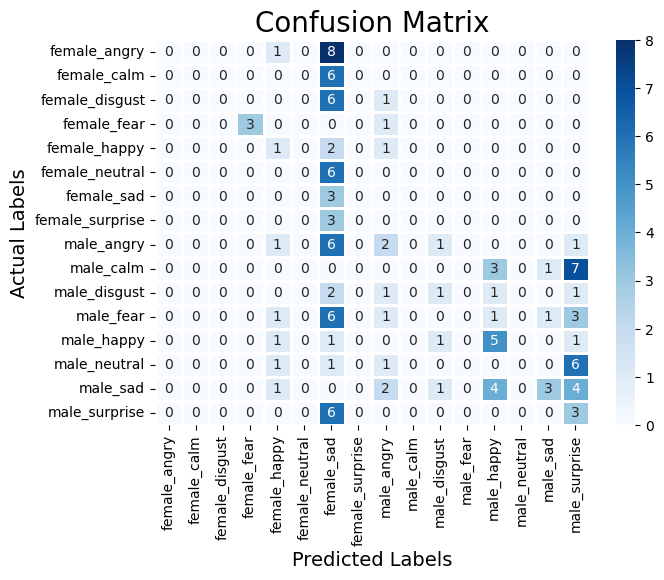

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (7, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()